In [1]:
import pandas as pd
import cv2
import dataclasses
import numpy as np
import matplotlib.pyplot as plt
import sys
import pickle
import os
import torch
import torchvision.transforms as transforms
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from torchvision.models import resnet50
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
LABEL_COLUMN = 'Counter'

DEVICE = 'cuda'

SAM_CHECKPOINT = 'model/sam/sam_vit_h_4b8939.pth'
SAM_MODEL_TYPE = 'vit_h'

In [3]:
TRAIN_DIR = 'dataset/1000'
TRAIN_FILE_NAMES = [
    '10uM_biotin_1000x__024.tif',
    # '10uM_biotin_1000x__025.tif',
    # '10uM_biotin_1000x__026.tif',
    # '20uM_biotin_1000x__041.tif',
    # '20uM_biotin_1000x__042.tif',
    # '20uM_biotin_1000x__043.tif',
    '20uM_biotin_1000x__045.tif',
    # '3-1k1.tif',
    '5uM_biotin_1000x__004.tif',
    # '5uM_biotin_1000x__006.tif',
    # '5uM_biotin_1000x__007.tif',
    # '5uM_biotin_1000x__008.tif',
    # 'naive RBCs_1000x__060.tif',
    # 'naive RBCs_1000x__061.tif',
    # 'naive RBCs_1000x__062.tif',
]

TEST_DIR = 'dataset/1000/test'
TEST_FILE_NAMES = [
    '10uM_biotin_1000x__027.tif',
    '20uM_biotin_1000x__046.tif',
    '5uM_biotin_1000x__009.tif',
    'naive RBCs_1000x__063.tif',
]

# To cut everything below this X. Default is 2048
X_THRESHOLD_FOR_FILE = {'3-1k1.tif': 1024}

IMAGEJ_LABEL_TO_CLASS_LABEL = {
    0: 0,
    1: 1,
    2: 2,
    3: 3,
}

AMBIGIOUS_CLASS_LABEL = 4

def threshold_for_file(filepath):
    filename = os.path.basename(filepath)
    if filename in X_THRESHOLD_FOR_FILE: return X_THRESHOLD_FOR_FILE[filename]

    return 2048

def _get_filepaths(dirname, filenames):
    filepaths = []
    for filename in filenames:
        filepaths.append(os.path.join(dirname, filename))
    
    return filepaths

def get_train_filepaths():
    filepaths = []
    filepaths.extend(_get_filepaths(TRAIN_DIR, TRAIN_FILE_NAMES))
    
    return filepaths

def get_test_filepaths():
    filepaths = []
    filepaths.extend(_get_filepaths(TEST_DIR, TEST_FILE_NAMES))
    
    return filepaths


def get_train_test_filepaths():
    filepaths = []
    filepaths.extend(_get_filepaths(TRAIN_DIR, TRAIN_FILE_NAMES))
    filepaths.extend(_get_filepaths(TEST_DIR, TEST_FILE_NAMES))
    
    return filepaths

In [4]:
def get_labels_filepath(image_filepath):
    return os.path.splitext(image_filepath)[0] + '.csv'

def get_masks_filepath(image_filepath):
    return os.path.splitext(image_filepath)[0] + '.pkl'

In [5]:
def preprocess_masks(masks, image):
    pass

    for mask in masks:
        mask['area'] = mask['segmentation'].sum()
    max_mask_area = max(mask['area'] for mask in masks)

    masks.sort(key=lambda mask: mask['area'])

    masks[:] = [mask for mask in masks if mask['area'] < max_mask_area]

    global_mask = np.full((image.shape[0], image.shape[1]), False)
    for mask in masks:
        x, y, w, h = mask['bbox']
        x, y, w, h = int(x), int(y), int(w), int(h)
        global_mask_crop = global_mask[y : y + h + 1, x : x + w + 1]
        mask['segmentation'][global_mask_crop] = False
        global_mask[y : y + h + 1, x : x + w + 1][mask['segmentation']] = True
        mask['area'] = mask['segmentation'].sum()

    masks.sort(key=lambda mask: mask['area'])

In [6]:
def label_masks(masks, image, labels: pd.DataFrame):
    label_is_found = set()
    mask_is_found = set()
    label_is_found_in_multiple_masks = set()
    for mask_index, mask in enumerate(masks):
        bbox = mask['bbox']
        segmentation = mask['segmentation']
        mask['ambigious'] = False
        mask['label'] = AMBIGIOUS_CLASS_LABEL
        matching_labels = 0
        x_0 = int(bbox[0])
        x_1 = int(bbox[0] + bbox[2])
        y_0 = int(bbox[1])
        y_1 = int(bbox[1] + bbox[3])
        for label_index, (x, y, label) in enumerate(zip(labels['X'], labels['Y'], labels[LABEL_COLUMN])):
            x = int(x)
            y = int(y)
            if x >= x_0 and x <= x_1 and y >= y_0 and y <= y_1 and segmentation[y - y_0, x - x_0]:
                matching_labels += 1
                if label_index in label_is_found:
                    label_is_found_in_multiple_masks.add(label_index)
                mask['label'] = IMAGEJ_LABEL_TO_CLASS_LABEL[label]
                label_is_found.add(label_index)
                mask_is_found.add(mask_index)
                
        if matching_labels > 1:
            mask['ambigious'] = True
            mask['label'] = AMBIGIOUS_CLASS_LABEL
    
    return label_is_found, mask_is_found, label_is_found_in_multiple_masks

In [7]:

def is_ambigious(mask):
    return mask['ambigious']

def show_masks(masks, image, mask_predicate=None, color_function=None, text_label=None, text_color=None):
    if len(masks) == 0:
        return
    ax = plt.gca()
    ax.set_autoscale_on(False)

    displayed = 0
    img = np.ones((image.shape[0], image.shape[1], 4))
    img[:,:,3] = 0
    for mask in masks:
        if mask_predicate and not mask_predicate(mask): continue
        (x, y, w, h) = mask['bbox']
        x, y, w, h = int(x), int(y), int(w), int(h)
        segmentation = mask['segmentation']
        if color_function:
            color_mask = color_function(mask)
        else:
            color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[y : y + h + 1, x : x + w + 1][segmentation] = color_mask
        if text_label:
            plt.text(x + w // 2, y + h // 2, text_label(mask))
        displayed += 1

    print('showing {} masks out of {}'.format(displayed, len(masks)))

    ax.imshow(img)


def show_predicted_non_ambigious_masks(masks, image):
    def _mask_color_by_predicted_label(label):
        if label == 0:
            return [1., 0, 0, 0.35]
        if label == 1:
            return [0, 1., 0, 0.35]
        if label == 2:
            return [0, 0, 1., 0.35]
        if label == 3:
            return [0.93, 0.7, 0.06, 0.35]

        return [0, 0, 0, 0.35]

    def _text_for_labels(mask):
        if mask['predicted_label'] == mask['label']: return None

        return (mask['probability'], mask['predicted_label'], mask['label'])

    plt.figure(figsize=(20,20))
    plt.imshow(image)
    show_masks(masks, image,
            mask_predicate=lambda mask: mask['predicted_label'] <= 3, 
            color_function=lambda mask: _mask_color_by_predicted_label(mask['predicted_label']),
            # text_label=_text_for_labels)
            text_label=None)
    plt.axis('off')
    plt.show() 

def show_ambigious_masks(masks, image):
    plt.figure(figsize=(20,20))
    plt.imshow(image)
    show_masks(masks, image, is_ambigious)
    plt.axis('off')
    plt.show() 

def show_ambigious_labels(masks, image, labels, label_is_found, label_is_found_in_multiple_masks, mask_is_found):
    plt.figure(figsize=(20,20))
    plt.imshow(image)
    show_masks(masks, image)
    for label_index, (x, y, label) in enumerate(zip(labels['X'], labels['Y'], labels[LABEL_COLUMN])):
        x = int(x)
        y = int(y)
        if label_index in label_is_found_in_multiple_masks:
            label_color = 'b*'
            s = 24
        elif label_index not in label_is_found:
            label_color = 'r*'
            s = 24
        else:
            label_color = 'g+'
            s = 11
        plt.plot(x, y, label_color, markersize=s)
    plt.axis('off')
    plt.show()

    ambigious_counter = sum(mask['ambigious'] for mask in masks)
    print('total labels: {}'.format(labels.shape[0]))
    print('labeled {} of {} ({}%)'.format(len(mask_is_found), len(masks), len(mask_is_found) / len(masks) * 100))
    print('{} labels not found'.format(labels.shape[0] - len(label_is_found)))
    print('ambigious: {}'.format(ambigious_counter))

In [8]:
# Define the transformation to apply to the image and mask
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def get_mask_resnet_features(mask, image, model):
    bbox = [int(x) for x in mask['bbox']]
    roi = image[bbox[1] : bbox[1] + bbox[3] + 1, bbox[0] : bbox[0] + bbox[2] + 1]
    masked_roi = roi * mask['segmentation'][:, :, np.newaxis]

    # Preprocess the image and mask
    preprocessed_roi = preprocess(masked_roi)

    # Expand the dimensions to match the input shape expected by ResNet
    preprocessed_roi = preprocessed_roi.unsqueeze(0)

    # Pass the preprocessed ROI through the model to obtain features
    with torch.no_grad():
        resnet_features = model(preprocessed_roi)
    
    # Flatten the feature tensor to obtain a feature vector
    feature_vector = resnet_features.view(resnet_features.size(0), -1).squeeze()

    return feature_vector.detach().cpu().numpy()

In [9]:
# Load the pre-trained ResNet model
resnet_model = resnet50(pretrained=True)

# Remove the classification layer from the model
features_extractor_model = torch.nn.Sequential(*list(resnet_model.children())[:-1])

# Set the model to evaluation mode
features_extractor_model.eval()

/usr/lib/python3/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/lib/python3/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [10]:
train_filepaths = get_train_filepaths()

classifier_X = []
classifier_y = []
for image_filepath in train_filepaths:
    labels_filepath = get_labels_filepath(image_filepath)
    masks_filepath = get_masks_filepath(image_filepath)
    print(image_filepath, labels_filepath, masks_filepath)

    image = cv2.imread(image_filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # image = image[:threshold_for_file(image_filepath), :, :]

    with open(masks_filepath,'rb') as f:
        masks = pickle.load(f)

    labels = pd.read_csv(labels_filepath, header=0, index_col=0)

    preprocess_masks(masks, image)
    label_is_found, mask_is_found, label_is_found_in_multiple_masks = label_masks(masks, image, labels)

    for mask in masks:
        if 'label' not in mask or mask['ambigious']:
            mask_label = AMBIGIOUS_CLASS_LABEL
        else:
            mask_label = mask['label']
        classifier_y.append(mask_label)
        classifier_X.append(get_mask_resnet_features(mask, image, features_extractor_model))

    # show_ambigious_masks(masks, image)
    # show_ambigious_labels(masks, image, labels, 
    #                       label_is_found=label_is_found,
    #                       label_is_found_in_multiple_masks=label_is_found_in_multiple_masks,
    #                       mask_is_found=mask_is_found)

print(len(classifier_X))
print(len(classifier_y))

dataset/1000/10uM_biotin_1000x__024.tif dataset/1000/10uM_biotin_1000x__024.csv dataset/1000/10uM_biotin_1000x__024.pkl
dataset/1000/20uM_biotin_1000x__045.tif dataset/1000/20uM_biotin_1000x__045.csv dataset/1000/20uM_biotin_1000x__045.pkl
dataset/1000/5uM_biotin_1000x__004.tif dataset/1000/5uM_biotin_1000x__004.csv dataset/1000/5uM_biotin_1000x__004.pkl
1773
1773


In [11]:
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(classifier_X, classifier_y, random_state=0)

knn_classifier = KNeighborsClassifier(n_neighbors=5, n_jobs=-1, algorithm='auto')
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1)

In [12]:
knn_classifier.classes_

array([0, 1, 2, 3, 4])

In [13]:
image_filepath = train_filepaths[0]
labels_filepath = get_labels_filepath(image_filepath)
masks_filepath = get_masks_filepath(image_filepath)
print(image_filepath, labels_filepath, masks_filepath)

image = cv2.imread(image_filepath)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image = image[:threshold_for_file(image_filepath), :, :]

with open(masks_filepath,'rb') as f:
    masks = pickle.load(f)

labels = pd.read_csv(labels_filepath, header=0, index_col=0)

preprocess_masks(masks, image)
label_is_found, mask_is_found, label_is_found_in_multiple_masks = label_masks(masks, image, labels)

for mask in masks:
    mask_features = get_mask_resnet_features(mask, image, features_extractor_model)
    predicted_label = knn_classifier.predict([mask_features])[0]
    mask['predicted_label'] = predicted_label
    mask['probability'] = max(knn_classifier.predict_proba([mask_features])[0])


dataset/1000/10uM_biotin_1000x__024.tif dataset/1000/10uM_biotin_1000x__024.csv dataset/1000/10uM_biotin_1000x__024.pkl


showing 189 masks out of 440


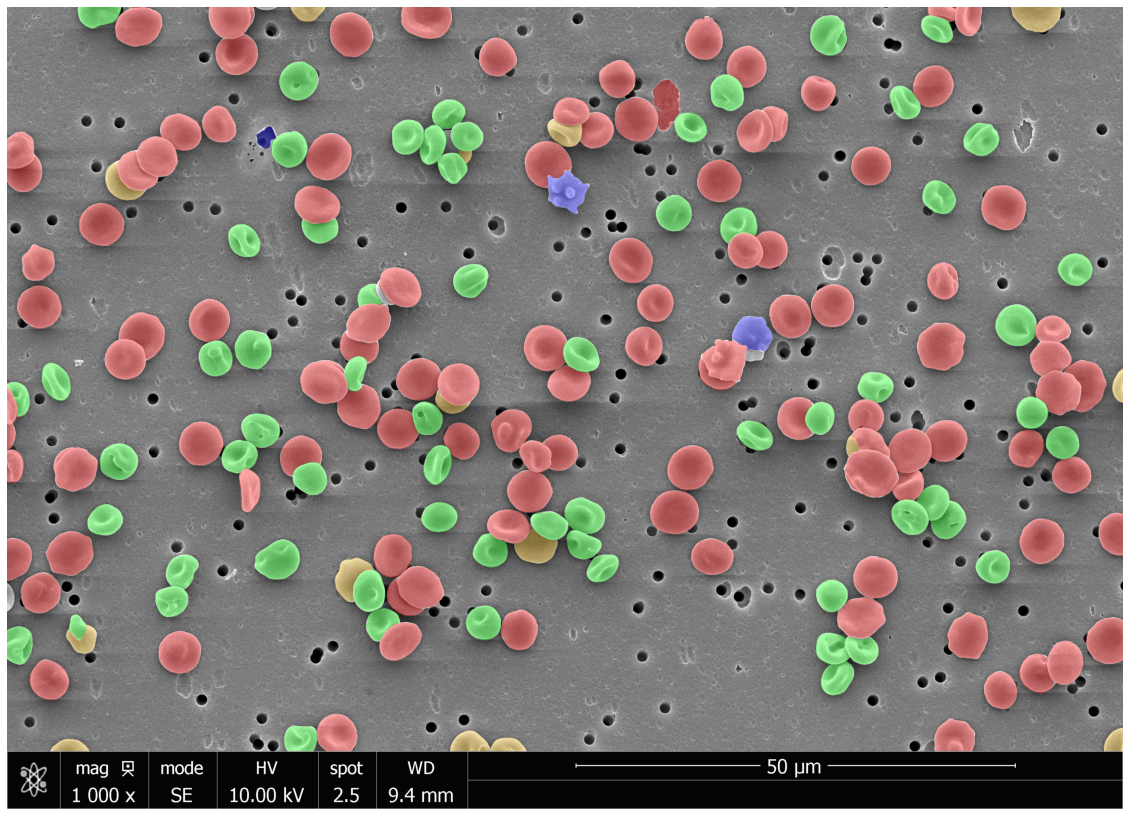

In [14]:
show_predicted_non_ambigious_masks(masks, image)

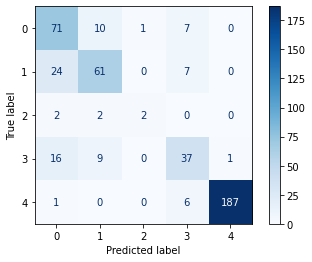

In [16]:
disp = ConfusionMatrixDisplay.from_estimator(
    knn_classifier,
    X_test,
    y_test,
    display_labels=[0, 1, 2, 3, 4],
    cmap=plt.cm.Blues,
    normalize=None,
)
plt.show()

In [17]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, knn_classifier.predict(X_test))

0.8063063063063063

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Define the fully connected neural network model
class Classifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Classifier, self).__init__()
        # self.fc0 = nn.Linear(input_size, 1024)
        # self.fc1 = nn.Linear(1024, 128)
        # self.fc2 = nn.Linear(128, 64)
        # self.fc3 = nn.Linear(64, 4)

        self.fc = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.BatchNorm1d(1024),  # Add batch normalization layer
            nn.ReLU(inplace=True),
            nn.Linear(1024, 128),
            nn.BatchNorm1d(128),  # Add batch normalization layer
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.fc(x)
        return x

# Set the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the ResNet features and labels
x_train_resnet_features = np.vstack(X_train)  # Shape: (num_examples, feature_size)
x_train_labels = []
for l in y_train:
    x_train_labels.append(np.zeros(5))
    x_train_labels[-1][l] = 1
x_train_labels = np.array(x_train_labels)

x_test_resnet_features = np.vstack(X_test)  # Shape: (num_examples, feature_size)
x_test_labels = []
for l in y_test:
    x_test_labels.append(np.zeros(5))
    x_test_labels[-1][l] = 1
x_test_labels = np.array(x_test_labels)

# Define hyperparameters
input_size = x_train_resnet_features.shape[1]
num_classes = x_train_labels.shape[1]
learning_rate = 0.001
batch_size = 64
num_epochs = 501

# Create the dataset and data loader
dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_train_resnet_features).float(), torch.from_numpy(x_train_labels).float())
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_test_resnet_features).float(), torch.from_numpy(x_test_labels).float())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create the model instance
dl_classifier = Classifier(input_size, num_classes).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(dl_classifier.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    dl_classifier.train()

    for features, targets in data_loader:
        features = features.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = dl_classifier(features)

        # Compute the loss
        loss = criterion(outputs, torch.argmax(targets, dim=1))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss for every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

    if epoch % 10 != 0: continue

    # Validation
    dl_classifier.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for features, targets in val_loader:
            features = features.to(device)
            targets = targets.argmax(dim=1).to(device)

            # Forward pass
            outputs = dl_classifier(features)

            # Compute the loss
            loss = criterion(outputs, targets)
            val_loss += loss.item() * features.size(0)

            # Count the correct predictions
            _, predicted = torch.max(outputs, dim=1)
            val_correct += (predicted == targets).sum().item()
            val_total += targets.size(0)

    val_accuracy = val_correct / val_total
    val_loss /= len(val_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss}, Val Accuracy: {val_accuracy}")


# Save the trained model
torch.save(dl_classifier.state_dict(), "model/cells_classifier/model.pt")

Epoch [1/501], Loss: 0.5381626486778259
Epoch [1/501], Val Loss: 0.5839693390571319, Val Accuracy: 0.7612612612612613
Epoch [2/501], Loss: 0.6480974555015564
Epoch [3/501], Loss: 0.3631913959980011
Epoch [4/501], Loss: 0.31820443272590637
Epoch [5/501], Loss: 0.29137611389160156
Epoch [6/501], Loss: 0.2595980763435364
Epoch [7/501], Loss: 0.1862727701663971
Epoch [8/501], Loss: 0.2178313136100769
Epoch [9/501], Loss: 0.202325239777565
Epoch [10/501], Loss: 0.1896732747554779
Epoch [11/501], Loss: 0.05520499497652054
Epoch [11/501], Val Loss: 0.6422549018988738, Val Accuracy: 0.8153153153153153
Epoch [12/501], Loss: 0.04542754590511322
Epoch [13/501], Loss: 0.021221725270152092
Epoch [14/501], Loss: 0.06417340785264969
Epoch [15/501], Loss: 0.03829982504248619
Epoch [16/501], Loss: 0.03327438607811928
Epoch [17/501], Loss: 0.02114541456103325
Epoch [18/501], Loss: 0.01757354475557804


Epoch [19/501], Loss: 0.047348104417324066
Epoch [20/501], Loss: 0.02066856436431408
Epoch [21/501], Loss: 0.020709697157144547
Epoch [21/501], Val Loss: 0.7114524809089867, Val Accuracy: 0.8243243243243243
Epoch [22/501], Loss: 0.006493121385574341
Epoch [23/501], Loss: 0.01502468716353178
Epoch [24/501], Loss: 0.009637141600251198
Epoch [25/501], Loss: 0.004797450266778469
Epoch [26/501], Loss: 0.012194661423563957
Epoch [27/501], Loss: 0.0225275419652462
Epoch [28/501], Loss: 0.001997221726924181
Epoch [29/501], Loss: 0.024984516203403473
Epoch [30/501], Loss: 0.0013269638875499368
Epoch [31/501], Loss: 0.002941759303212166
Epoch [31/501], Val Loss: 0.8018839890892441, Val Accuracy: 0.8288288288288288
Epoch [32/501], Loss: 0.010227065533399582
Epoch [33/501], Loss: 0.0007377259316854179
Epoch [34/501], Loss: 0.007728370372205973
Epoch [35/501], Loss: 0.05819001793861389
Epoch [36/501], Loss: 0.015075338073074818
Epoch [37/501], Loss: 0.06969335675239563
Epoch [38/501], Loss: 0.01172

dataset/1000/test/10uM_biotin_1000x__027.tif dataset/1000/test/10uM_biotin_1000x__027.csv dataset/1000/test/10uM_biotin_1000x__027.pkl
showing 201 masks out of 426


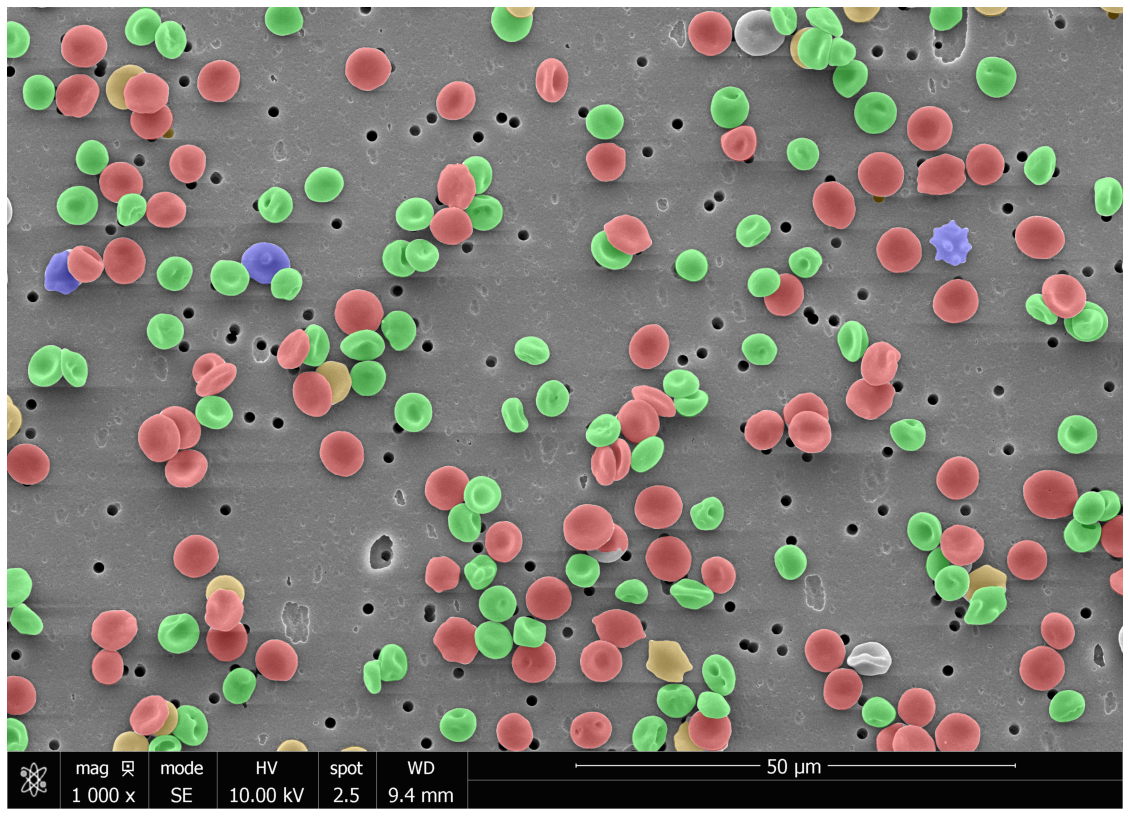

dataset/1000/test/20uM_biotin_1000x__046.tif dataset/1000/test/20uM_biotin_1000x__046.csv dataset/1000/test/20uM_biotin_1000x__046.pkl
showing 266 masks out of 472


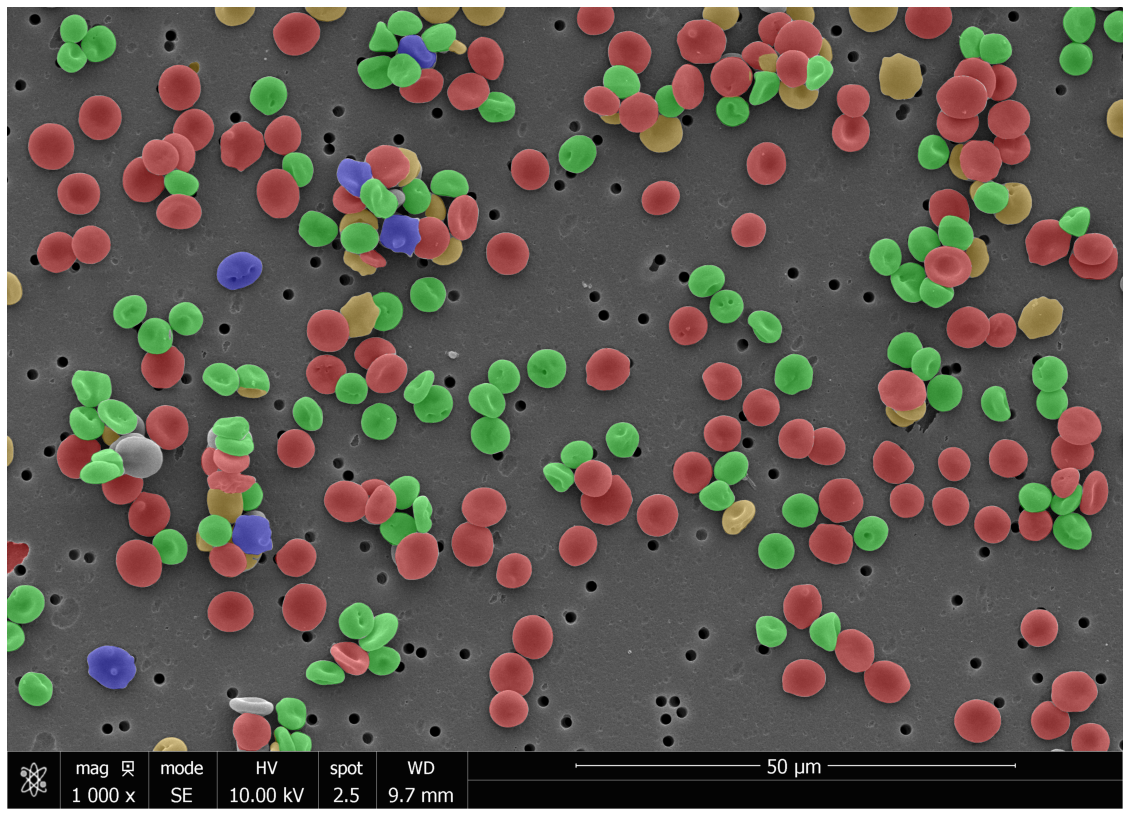

dataset/1000/test/5uM_biotin_1000x__009.tif dataset/1000/test/5uM_biotin_1000x__009.csv dataset/1000/test/5uM_biotin_1000x__009.pkl
showing 309 masks out of 522


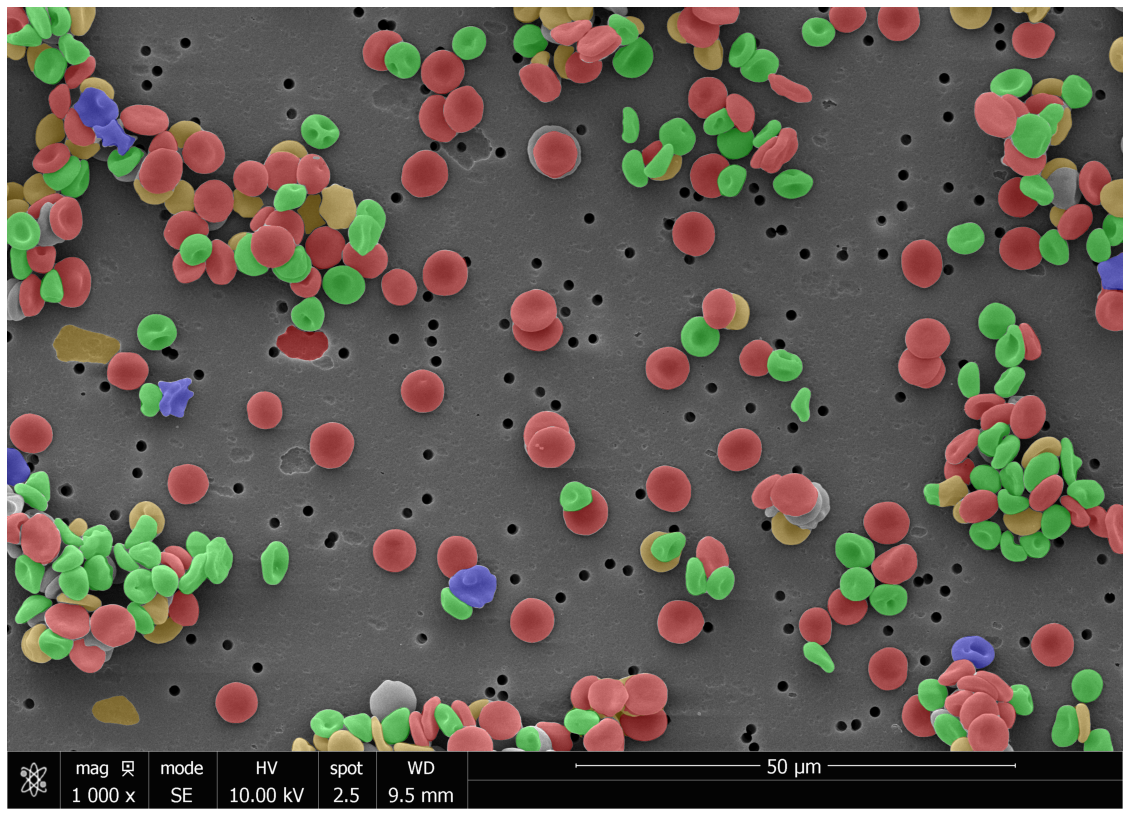

dataset/1000/test/naive RBCs_1000x__063.tif dataset/1000/test/naive RBCs_1000x__063.csv dataset/1000/test/naive RBCs_1000x__063.pkl
showing 193 masks out of 419


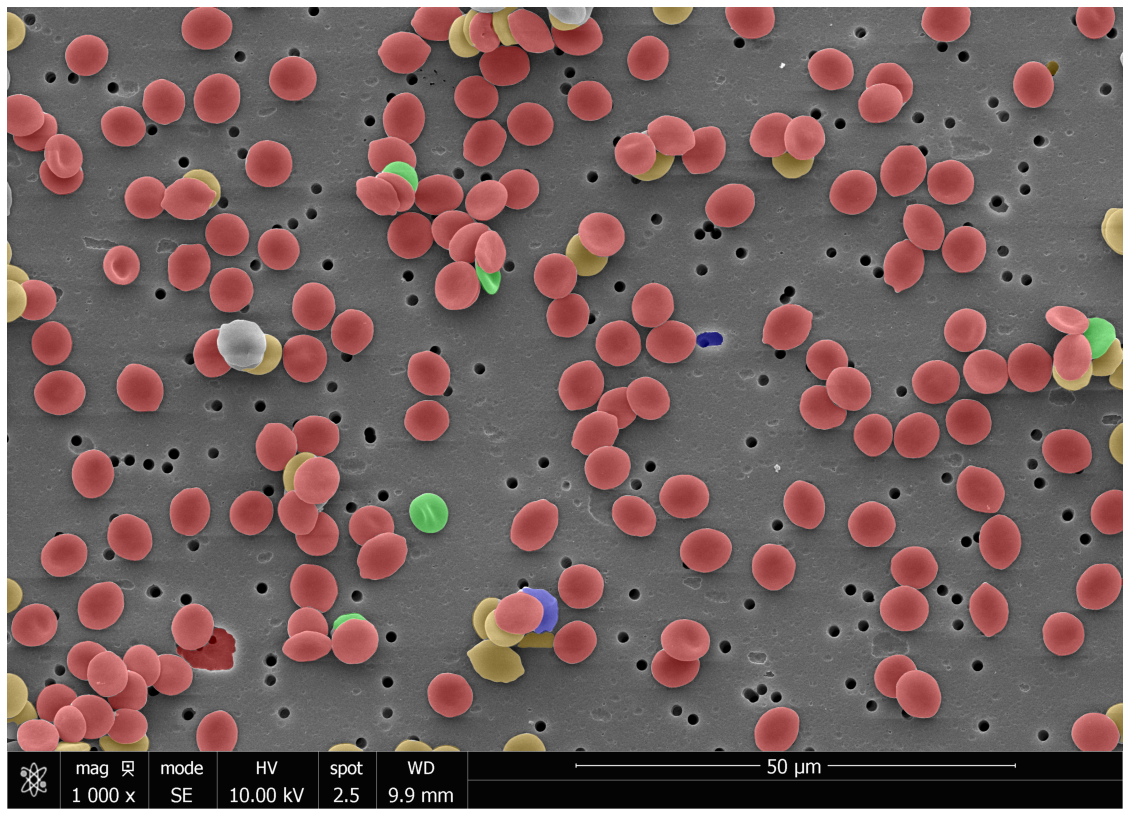

In [21]:
test_filepaths = get_test_filepaths()

dl_classifier.eval()

for image_filepath in test_filepaths:
    labels_filepath = get_labels_filepath(image_filepath)
    masks_filepath = get_masks_filepath(image_filepath)
    print(image_filepath, labels_filepath, masks_filepath)

    image = cv2.imread(image_filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # image = image[:threshold_for_file(image_filepath), :, :]

    with open(masks_filepath,'rb') as f:
        masks = pickle.load(f)

    labels = pd.read_csv(labels_filepath, header=0, index_col=0)

    preprocess_masks(masks, image)
    label_is_found, mask_is_found, label_is_found_in_multiple_masks = label_masks(masks, image, labels)

    for mask in masks:
        resnet_features = get_mask_resnet_features(mask, image, features_extractor_model)

        # Convert features to a tensor
        features_tensor = torch.tensor(resnet_features).unsqueeze(0).to(device)

        # Perform forward pass
        with torch.no_grad():
            outputs = dl_classifier(features_tensor)

        # Process the outputs (example: multiclass classification)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_label = torch.argmax(probabilities, dim=1)

        # Convert the predicted labels to a numpy array
        predicted_label = int(predicted_label.cpu().numpy())

        mask['predicted_label'] = predicted_label
        mask['probability'] = torch.max(probabilities).item()
    show_predicted_non_ambigious_masks(masks, image)